In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F
from experiments.base.shifts import WeatherShiftsDataset
from training.util import nll_loss, adam, sgd, EarlyStopper

dataset = WeatherShiftsDataset("/mnt/d/Uni/Bachelorarbeit/linux/data/")

/home/flo/anaconda3/envs/bdl2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cpu")

In [3]:
batch_size = 512
trainloader = dataset.trainloader(batch_size, small=True)
valloader = dataset.in_valloader(1000)
init_std = torch.tensor(0.1)

In [4]:
def validate(model):
    with torch.no_grad():
        loss = 0
        for data, target in valloader:
            output = model(data, 100).mean(dim=0)
            loss += nll_loss(output, target).detach().item()
        return loss / len(valloader)

In [ ]:
from training.bbb import GaussianPrior, BBBModel

prior = GaussianPrior(0, 1)
layers = [
    ("v_fc", (123, 250, prior, {})),
    ("relu", ()),
    ("v_fc", (250, 250, prior, {})),
    ("relu", ()),
    ("v_fc", (250, 1, prior, {})),
    ("gauss", (init_std, True)),
]

model = BBBModel(layers)
model.train_model(10, nll_loss, adam(0.003), trainloader, 512, device, mc_samples=2, kl_rescaling=0.2, report_every_epochs=1)


In [28]:
from training.vogn import VOGNModule, iVONModuleFunctorch

layers = [
    ("fc", (123, 256)),
    ("relu", ()),
    ("fc", (256, 512)),
    ("relu", ()),
    ("fc", (512, 256)),
    ("relu", ()),
    ("fc", (256, 128)),
    ("relu", ()),
    ("fc", (128, 1)),
    ("gauss", (init_std, True)),
]

model = iVONModuleFunctorch(layers)
model.train_model(10, nll_loss, {"lr": 3e-3, "prior_prec": 100, "damping": 1e-3, "betas": (0.9, 0.999), "sample": True}, trainloader, batch_size, device, mc_samples=2)

Epoch 0: loss 2.1840457916259766
Epoch 1: loss -0.8537770509719849
Epoch 2: loss -0.9290555119514465
Epoch 3: loss -0.9808865785598755
Epoch 4: loss -1.017924427986145
Epoch 5: loss -1.036207675933838
Epoch 6: loss -1.0351866483688354
Epoch 7: loss -1.0352941751480103
Epoch 8: loss -1.0479520559310913
Epoch 9: loss -1.0319256782531738
Final loss -1.0319256782531738


In [30]:
from training.pp import MAP
from training.swag import SwagModel

p = 0.2
layers = [
    ("dropout", (p,)),
    ("fc", (123, 250)),
    ("dropout", (p,)),
    ("relu", ()),
    ("fc", (250, 250)),
    ("dropout", (p,)),
    ("relu", ()),
    ("fc", (250, 1)),
    ("gauss", (init_std, True)),
]

model = MAP(layers)
model.train_model(50, nll_loss, adam(3e-3), trainloader, batch_size, device)

Epoch 0: loss 2.595972776412964
Epoch 1: loss 0.4667265713214874
Epoch 2: loss 0.02813771553337574
Epoch 3: loss -0.218293696641922
Epoch 4: loss -0.43715429306030273
Epoch 5: loss -0.5821081399917603
Epoch 6: loss -0.6841873526573181
Epoch 7: loss -0.7302435636520386
Epoch 8: loss -0.7684341073036194
Epoch 9: loss -0.8158431649208069
Epoch 10: loss -0.8404673337936401
Epoch 11: loss -0.8662179112434387
Epoch 12: loss -0.8714732527732849
Epoch 13: loss -0.8865500092506409
Epoch 14: loss -0.8997650146484375
Epoch 15: loss -0.9085706472396851
Epoch 16: loss -0.9146618843078613
Epoch 17: loss -0.9211964011192322
Epoch 18: loss -0.9217075705528259
Epoch 19: loss -0.9288759827613831
Epoch 20: loss -0.9236927032470703
Epoch 21: loss -0.9224843382835388
Epoch 22: loss -0.9266132116317749
Epoch 23: loss -0.9291160106658936
Epoch 24: loss -0.9360290765762329
Epoch 25: loss -0.9246293902397156
Epoch 26: loss -0.9316752552986145
Epoch 27: loss -0.9406249523162842
Epoch 28: loss -0.942062377929687

In [14]:
model.model[-1].var.sqrt()

TypeError: 'FunctionalModuleWithBuffers' object is not subscriptable

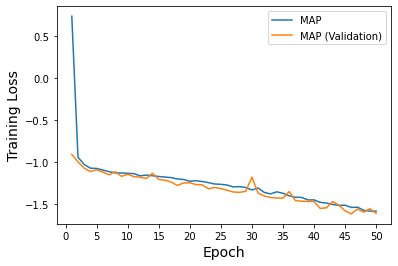

In [10]:
import matplotlib.pyplot as plt
from training.util import plot_losses

plot_losses("MAP", model.all_losses(), plt.subplot(), val_losses=es.losses)

In [15]:
in_testloader = dataset.in_testloader(batch_size)
out_testloader = dataset.out_testloader(batch_size)

In [31]:
from training.regresssion import RegressionResults

res = RegressionResults(in_testloader, "MAP", model.infer, 10, device, target_mean=dataset.target_mean, target_std=dataset.target_std)
print(res.mse_of_means)
print(res.qce)

tensor(26.0489)
tensor(0.2685)


In [25]:
from training.regresssion import RegressionResults

res = RegressionResults(out_testloader, "MAP", model.infer, 10, device, target_mean=dataset.target_mean, target_std=dataset.target_std)
print(res.mse_of_means)
print(res.qce)

tensor(6.8564)
tensor(0.0490)
